# Feature Selection Tutorial

## 1. Introduction to Feature Selection

## 2. Introduction to Lasso

In [170]:
import matplotlib
import matplotlib.pyplot as plt 

import numpy as np

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LinearRegression, lasso_path, lasso_stability_path, lars_path

%matplotlib inline 

## 3. Variants of Lasso

## 4. References
1. Guyon, Isabelle, and André Elisseeff. "An introduction to variable and feature selection." Journal of machine learning research 3.Mar (2003): 1157-1182. [link](http://www.jmlr.org/papers/volume3/guyon03a/guyon03a.pdf)
* Feature selection - Wikipedia. [link](https://en.wikipedia.org/wiki/Feature_selection)

* Sklearn [link](http://scikit-learn.org/stable/modules/feature_selection.html#randomized-l1)
* F. Bach, Model-Consistent Sparse Estimation through the Bootstrap. [link]( https://hal.inria.fr/hal-00354771/)
* N. Meinshausen, P. Buhlmann, Stability selection, Journal of the Royal Statistical Society, 72 (2010)[link](http://arxiv.org/pdf/0809.2932.pdf)
* http://stats.stackexchange.com/questions/45643/why-l1-norm-for-sparse-models
* UCI Machine Learning Repository [link](http://archive.ics.uci.edu/ml/index.html)
* http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/
* http://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_recovery.html#sphx-glr-auto-examples-linear-model-plot-sparse-recovery-py
* http://statistics.berkeley.edu/sites/default/files/tech-reports/709.pdf
* Covariance, covariance is a measure of how much two random variables change together https://en.wikipedia.org/wiki/Covariance

## Experiment Design
### Lasso
* Dataset: synthetic examples, UCL ML dataset (regression, classification)
    * y = x_0 + 0.5 x_1 + 0 * x_2 + noise
    * y = x_0 + x_0 + noise
* Regression path (different lambda/alpha)
    * How will the weight/coefficient (same scale?) for each feature change with the lambda/alpha, @M2009 figure 1,4,7
* Performance:
    * How many features remain (relevent/irrelevent)
    * Task performance


### Bolasso & Bolasso-S


In [160]:
import matplotlib
import matplotlib.pyplot as plt 

import numpy as np

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LinearRegression, lasso_path, lasso_stability_path, lars_path

import warnings


from scipy import linalg

from sklearn.linear_model import (RandomizedLasso, lasso_stability_path,
                                  LassoLarsCV)
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, precision_recall_curve
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.utils.extmath import pinvh
from sklearn.exceptions import ConvergenceWarning

%matplotlib inline 

In [203]:
def mutual_incoherence(X_relevant, X_irelevant):
    """Mutual incoherence, as defined by formula (26a) of [Wainwright2006].
    """
    projector = np.dot(np.dot(X_irelevant.T, X_relevant),
                       pinvh(np.dot(X_relevant.T, X_relevant)))
    return np.max(np.abs(projector).sum(axis=1))


def plot_sel_path(X, y, coef, method='Lasso'):
    """Plot feature selection result
    """
    if method == 'Lasso':
        alpha_grid, _, scores_path = lars_path(X, y, method='lasso', eps=0.05)
    elif method == 'Stability':
        alpha_grid, scores_path = lasso_stability_path(X, y, eps=0.05)
        
    plt.figure()
    hg = plt.plot(alpha_grid[1:] ** .333, scores_path[coef != 0].T[1:], 'r')
    hb = plt.plot(alpha_grid[1:] ** .333, scores_path[coef == 0].T[1:], 'k')
    ymin, ymax = plt.ylim()
    plt.xlabel(r'$(\alpha / \alpha_{max})^{1/3}$')
    plt.ylabel('Stability score: proportion of times selected')
    mi = mutual_incoherence(X[:, coef != 0],
                            X[:, coef == 0])
    plt.title('Stability Scores Path - Mutual incoherence: %.1f' % mi)
    plt.axis('tight')
    plt.legend((hg[0], hb[0]), ('relevant features', 'irrelevant features'),
               loc='best')   
    
def plot_sel_auc(X, y, coef, methods=['Lasso', 'Stability']):
    """Plot feature selection auc
    """
    models = {}
    for m in methods:
        if m == 'Lasso':
            sel_m = LassoLarsCV(cv=6).fit(X, y)
            score = np.abs(sel_m.coef_)
        elif m == 'Stability':
            sel_m = RandomizedLasso().fit(X, y)
            score = sel_m.scores_
        models[m] = score

    plt.figure()
    for name in models:
        score = models[name]
        n_rel = np.sum(coef != 0)
        precision, recall, thresholds = precision_recall_curve(coef != 0, score)
        print n_rel

        plt.plot(n_rel/recall, recall, 
                 label="%s. AUC: %.3f" % (name, auc(recall, precision)))
       
    plt.show()

#     plt.plot(np.where(coef != 0)[0], [2e-4] * n_relevant_features, 'mo',
#              label="Ground truth")
#     plt.xlabel("Features")
#     plt.ylabel("Score")
    # Plot only the 100 first coefficients
#     plt.xlim(0, 100)
#     plt.legend(loc='best')
#     plt.title('Feature selection scores - Mutual incoherence: %.1f'
#               % mi)    

5
5


/Users/jinyi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in divide


NameError: global name 'plot' is not defined

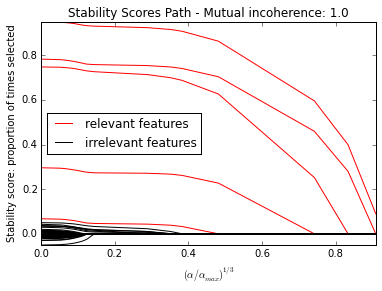

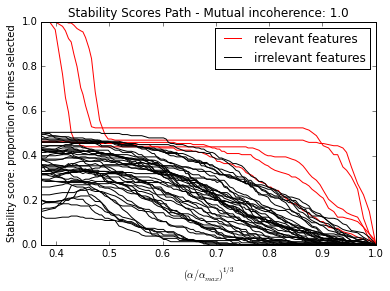

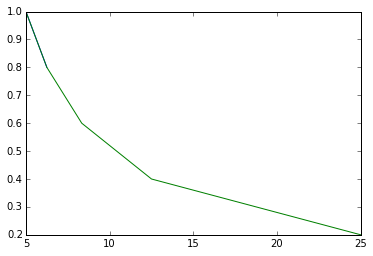

In [204]:
n_sample = 1000
n_feature = 50
n_relevant_feature = 5
noise_level = 0.2

rng = np.random.RandomState(0)

X = rng.rand(n_sample, n_feature)
coef = np.zeros(n_feature)
coef[:n_relevant_feature] = rng.rand(n_relevant_feature)
y = np.dot(X, coef)
y += noise_level * rng.normal(size=n_sample)

plot_sel_path(X, y, coef, "Lasso")

plot_sel_path(X, y, coef, "Stability")

plot_sel_auc(X, y, coef)

In [123]:
def plot_reg_path(alphas, coefs, f, log_x=False):
    print alphas.shape, coefs.shape
    for i in range(coefs.shape[0]):
        plt.plot(alphas, coefs[i,:], label=f[i])
        if log_x:
            plt.xscale('log')
    plt.legend()
    plt.show()

def plot_lasso_reg_path(X, y, alphas, f, log_x=False):
    alphas, coef_path, _ = lasso_path(X, y, alphas=alphas)
    plot_reg_path(alphas, coef_path, f, log_x)
    
def plot_lasso_stability_path(X, y, f, log_x=False):
    alphas, coef_path = lasso_stability_path(X, y)
    plot_reg_path(alphas, coef_path, f, log_x)

[ 1.12552861  0.80844367  0.9096971   0.87199269  0.99381066]
[ 0.         -0.          1.47771429  0.          0.89119841]
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9]
(10,) (5, 10)


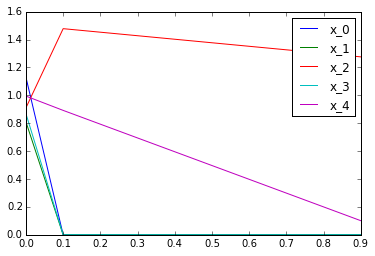

(102,) (5, 102)


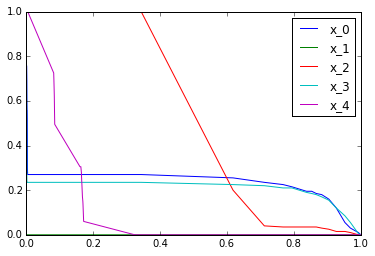

In [129]:
np.random.seed(1)

# Exp 1
n_data = 5000
noise = np.random.normal(0, 1, n_data)
x_seed = np.random.normal(0, 1, n_data)
x_0 = 1 * x_seed + np.random.normal(0, 0.1, n_data)
x_1 = -1 * x_seed + np.random.normal(0, 0.1, n_data)
x_2 = 2 * x_seed + np.random.normal(0, 0.1, n_data)
x_3 = 1 * x_seed + np.random.normal(0, 0.1, n_data)
x_4 = np.random.normal(0, 1, n_data)

X = np.array([x_0, x_1, x_2, x_3, x_4]).T

y = np.sum(X, axis=1) + noise
# y = X[:,0] + X[:,1] + X[:,2] + noise

lr = LinearRegression()
lr.fit(X, y)
print lr.coef_

lr = Lasso(alpha=0.1)
lr.fit(X, y)
print lr.coef_

# plot reg path for lasso on exp 1
alphas = np.arange(0.0, 1.0, 0.1)
# alphas = np.logspace(0.0,0.1,10)
print alphas
plot_lasso_reg_path(X, y, alphas, ['x_0', 'x_1', 'x_2', 'x_3', 'x_4'])

plot_lasso_stability_path(X, y, ['x_0', 'x_1', 'x_2', 'x_3', 'x_4'])

In [121]:
# exp 2 when lasso fails but bolasso success

Automatically created module for IPython interactive environment
(501, 103)
(501, 171)
(501, 102)
(501, 501)


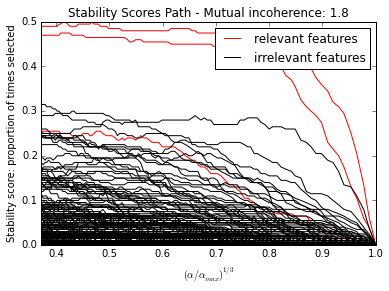

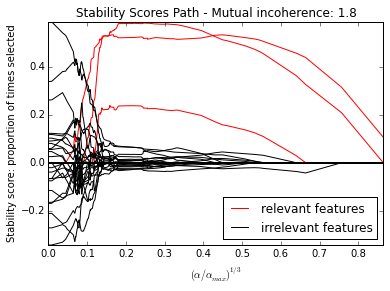

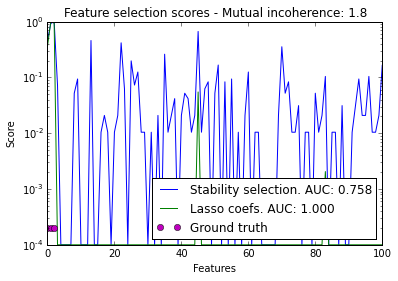

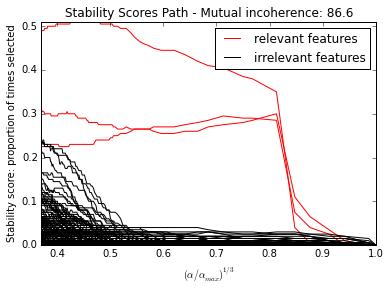

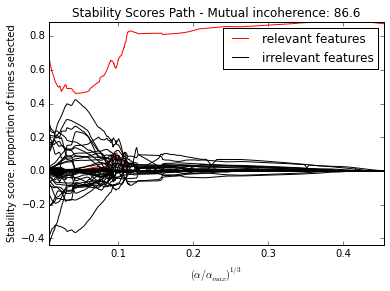

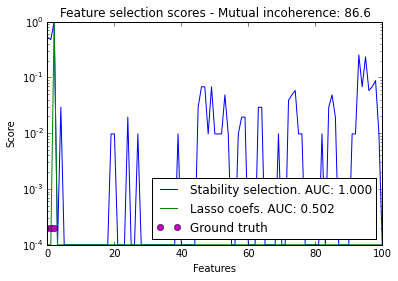

In [169]:
print(__doc__)

# Author: Alexandre Gramfort and Gael Varoquaux
# License: BSD 3 clause

import warnings

import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

from sklearn.linear_model import (RandomizedLasso, lasso_stability_path,
                                  LassoLarsCV)
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, precision_recall_curve
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.utils.extmath import pinvh
from sklearn.exceptions import ConvergenceWarning


def mutual_incoherence(X_relevant, X_irelevant):
    """Mutual incoherence, as defined by formula (26a) of [Wainwright2006].
    """
    projector = np.dot(np.dot(X_irelevant.T, X_relevant),
                       pinvh(np.dot(X_relevant.T, X_relevant)))
    return np.max(np.abs(projector).sum(axis=1))


for conditioning in (1, 1e-4):
    ###########################################################################
    # Simulate regression data with a correlated design
    n_features = 501
    n_relevant_features = 3
    noise_level = .2
    coef_min = .2
    # The Donoho-Tanner phase transition is around n_samples=25: below we
    # will completely fail to recover in the well-conditioned case
    n_samples = 25
    block_size = n_relevant_features

    rng = np.random.RandomState(42)

    # The coefficients of our model
    coef = np.zeros(n_features)
    coef[:n_relevant_features] = coef_min + rng.rand(n_relevant_features)

    # The correlation of our design: variables correlated by blocs of 3
    corr = np.zeros((n_features, n_features))
    for i in range(0, n_features, block_size):
        corr[i:i + block_size, i:i + block_size] = 1 - conditioning
    corr.flat[::n_features + 1] = 1
    corr = linalg.cholesky(corr)

    # Our design
    X = rng.normal(size=(n_samples, n_features))
    X = np.dot(X, corr)
    # Keep [Wainwright2006] (26c) constant
    X[:n_relevant_features] /= np.abs(
        linalg.svdvals(X[:n_relevant_features])).max()
    X = StandardScaler().fit_transform(X.copy())

    # The output variable
    y = np.dot(X, coef)
    y /= np.std(y)
    # We scale the added noise as a function of the average correlation
    # between the design and the output variable
    y += noise_level * rng.normal(size=n_samples)
    mi = mutual_incoherence(X[:, :n_relevant_features],
                            X[:, n_relevant_features:])

    ###########################################################################
    # Plot stability selection path, using a high eps for early stopping
    # of the path, to save computation time
    alpha_grid, scores_path = lasso_stability_path(X, y, random_state=42, eps=0.05)
    print scores_path.shape
#     alpha_grid, scores_path, _ = lasso_path(X, y, random_state=42, eps=0.05)

    plt.figure()
    # We plot the path as a function of alpha/alpha_max to the power 1/3: the
    # power 1/3 scales the path less brutally than the log, and enables to
    # see the progression along the path
    hg = plt.plot(alpha_grid[1:] ** .333, scores_path[coef != 0].T[1:], 'r')
    hb = plt.plot(alpha_grid[1:] ** .333, scores_path[coef == 0].T[1:], 'k')
    ymin, ymax = plt.ylim()
    plt.xlabel(r'$(\alpha / \alpha_{max})^{1/3}$')
    plt.ylabel('Stability score: proportion of times selected')
    plt.title('Stability Scores Path - Mutual incoherence: %.1f' % mi)
    plt.axis('tight')
    plt.legend((hg[0], hb[0]), ('relevant features', 'irrelevant features'),
               loc='best')
    
#     alpha_grid, scores_path = lasso_stability_path(X, y, random_state=42, eps=0.05)
#     alpha_grid, scores_path, _ = lasso_path(X, y, random_state=42, eps=0.05)
    alpha_grid, _, scores_path = lars_path(X, y, method='lasso', eps=0.05)
    print scores_path.shape

    plt.figure()
    # We plot the path as a function of alpha/alpha_max to the power 1/3: the
    # power 1/3 scales the path less brutally than the log, and enables to
    # see the progression along the path
    hg = plt.plot(alpha_grid[1:] ** .333, scores_path[coef != 0].T[1:], 'r')
    hb = plt.plot(alpha_grid[1:] ** .333, scores_path[coef == 0].T[1:], 'k')
    ymin, ymax = plt.ylim()
    plt.xlabel(r'$(\alpha / \alpha_{max})^{1/3}$')
    plt.ylabel('Stability score: proportion of times selected')
    plt.title('Stability Scores Path - Mutual incoherence: %.1f' % mi)
    plt.axis('tight')
    plt.legend((hg[0], hb[0]), ('relevant features', 'irrelevant features'),
               loc='best')

    ###########################################################################
    # Plot the estimated stability scores for a given alpha

    # Use 6-fold cross-validation rather than the default 3-fold: it leads to
    # a better choice of alpha:
    # Stop the user warnings outputs- they are not necessary for the example
    # as it is specifically set up to be challenging.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', UserWarning)
        warnings.simplefilter('ignore', ConvergenceWarning)
        lars_cv = LassoLarsCV(cv=6).fit(X, y)

    # Run the RandomizedLasso: we use a paths going down to .1*alpha_max
    # to avoid exploring the regime in which very noisy variables enter
    # the model
    alphas = np.linspace(lars_cv.alphas_[0], .1 * lars_cv.alphas_[0], 6)
    clf = RandomizedLasso(alpha=alphas, random_state=42).fit(X, y)
    trees = ExtraTreesRegressor(100).fit(X, y)
    # Compare with F-score
    F, _ = f_regression(X, y)

    plt.figure()
    for name, score in [
#                         ('F-test', F),
                        ('Stability selection', clf.scores_),
                        ('Lasso coefs', np.abs(lars_cv.coef_))
#                         ('Trees', trees.feature_importances_),
                        ]:
        precision, recall, thresholds = precision_recall_curve(coef != 0,
                                                               score)
        plt.semilogy(np.maximum(score / np.max(score), 1e-4),
                     label="%s. AUC: %.3f" % (name, auc(recall, precision)))

    plt.plot(np.where(coef != 0)[0], [2e-4] * n_relevant_features, 'mo',
             label="Ground truth")
    plt.xlabel("Features")
    plt.ylabel("Score")
    # Plot only the 100 first coefficients
    plt.xlim(0, 100)
    plt.legend(loc='best')
    plt.title('Feature selection scores - Mutual incoherence: %.1f'
              % mi)

plt.show()